In [486]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yaml
import math
from dask import dataframe as dd
from dask_ml.preprocessing import MinMaxScaler

from sklearn.decomposition import PCA

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p
from sklearn import datasets, linear_model

from sklearn import tree
from sklearn.tree import DecisionTreeClassifier


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, ShuffleSplit, \
        validation_curve, cross_validate, train_test_split, KFold, cross_val_predict
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelBinarizer, RobustScaler, PolynomialFeatures
from sklearn.cluster import KMeans

from gplearn.genetic import SymbolicTransformer

#warnings.simplefilter(action='ignore')    
original_day = dd.read_csv('Data/day.csv')
original_hour= dd.read_csv('Data/hour.csv')

day_url = 'https://docs.google.com/spreadsheets/d/1B0gimSI9LIISR0cNJW-B-hrn6pj0kTwczLYGgVZxGd0/edit?usp=sharing'
# original_day = dd.DataFrame(wget.download(day_url))

# original_day = wget.download(day_url)
    

In [372]:
raw_day_df=original_day.copy()
raw_day_df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
npartitions=1,,,,,,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [373]:
raw_hour_df=original_hour.copy()
raw_hour_df.describe()

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
npartitions=1,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [374]:
raw_day_df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [375]:
raw_hour_df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [376]:
raw_day_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 16 entries, instant to cnt
dtypes: object(1), float64(4), int64(11)

In [377]:
raw_hour_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 17 entries, instant to cnt
dtypes: object(1), float64(4), int64(12)

# 1. Data Cleaning and Preparation

## 1.2 Checking for missing values

In [378]:
raw_day_df.isnull().values.any().compute()

False

In [379]:
raw_hour_df.isnull().values.any().compute()

False

## 1.2 Checking for correctness in dates

In [380]:
raw_hour_df['dteday'] = dd.to_datetime(raw_hour_df.dteday)

First check if column 'mnth' corresponds to the month value from 'dteday' column

In [381]:
all(raw_hour_df['dteday'].dt.month.compute() == raw_hour_df['mnth'].compute())

True

Then check if column 'yr' corresponds to the year values from 'dteday' column represented as binary

In [382]:
binary_year = pd.Series(raw_hour_df['dteday'].dt.year.compute() == 2012)
all(binary_year == raw_hour_df['yr'].astype('bool').compute())

True

Finally, create a 'day' column that represents the day of the month

In [383]:
raw_hour_df[(raw_hour_df.season == 4) & (raw_hour_df.mnth == 12)].head(2)

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
7904,7905,2011-12-01,4,0,12,0,0,4,1,1,0.28,0.2576,0.52,0.3284,1,19,20
7905,7906,2011-12-01,4,0,12,1,0,4,1,1,0.26,0.2424,0.60,0.2836,1,9,10


Defining previous steps as function to later use in data preparation pipeline:

## 1.2 Data preparation 

### 1.2.1 Data preparation functions

In [384]:
def fix_types(df):
    df[['season','mnth', 'weekday','weathersit']] = df[['season','mnth', 'weekday','weathersit']].astype('category')
    df[['yr', 'holiday', 'workingday']] = df[['yr', 'holiday', 'workingday']].astype('uint8')
    return df

In [483]:
def feature_skewness(df):
    numeric_dtypes = ['float64'] ##
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x), axis = 1).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features

def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x), axis = 1).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df

In [501]:
def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df)
    return(list(set(df.columns) - set(numerical_columns)))

def onehot_encode(df):
    numericals = df[numerical_features(df)]
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df

### Data Preparation Pipeline

In [387]:
std_scale = MinMaxScaler().fit(raw_hour_df[['atemp', 'hum', 'windspeed']])
raw_hour_df[['atemp', 'hum', 'windspeed']] = std_scale.transform(raw_hour_df[['atemp','hum', 'windspeed']])

In [388]:
def standardize_data(df):
    std_scale = MinMaxScaler().fit(df[['atemp', 'hum', 'windspeed']])
    df[['atemp', 'hum', 'windspeed']] = std_scale.transform(df[['atemp', 'hum', 'windspeed']])
    
    return df

In [389]:
def standardize_hour(df):
    df[['hr']] = df[['hr']].astype('category')
    df = onehot_encode(df)
    
    return df

In [390]:
def drop_columns(df):
    df = df.drop(['instant'], axis = 1)
    return df

In [457]:
wCol= ["season","weathersit","hum","mnth","temp","yr","atemp"]

dataWind0 = raw_hour_df[raw_hour_df["windspeed"]==0]
dataWindNot0 = raw_hour_df[raw_hour_df["windspeed"]!=0]
dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")

dataWindNot0= cull_empty_partitions(dataWindNot0)
dataWind0 = cull_empty_partitions(dataWind0)
rfModel_wind = RandomForestClassifier().fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

wind0Values = dd.from_array(rfModel_wind.predict(X= dataWind0[wCol]))


In [455]:
from sklearn.ensemble import RandomForestClassifier

def fix_wind(df):
    wCol= ["season","weathersit","hum","mnth","temp","yr","atemp"]

    dataWind0 = df[(df["windspeed"]==0).compute()]
    dataWindNot0 = df[(df["windspeed"]!=0).compute()]
    dataWindNot0["windspeed"] = dataWindNot0["windspeed"].astype("str")
    
    rfModel_wind = RandomForestClassifier().fit(dataWindNot0[wCol], dataWindNot0["windspeed"])

    wind0Values = dd.from_array(rfModel_wind.predict(X= dataWind0[wCol]))

    dataWind0["windspeed"] = wind0Values
    df = dataWindNot0.append(dataWind0)
    df["windspeed"] = df["windspeed"].astype("float")
    df.reset_index(inplace=True)
    df.drop('index',inplace=True,axis=1)
    
    df = df.sort_values(by=['dteday', 'hr']).reset_index(drop=True)
    
    return df

In [503]:
#dataset_fixed = fix_types(fix_skewness(standardize_data(drop_columns(fix_wind(raw_hour_df)))))
#dataset_fixed = fix_types(fix_skewness(standardize_data(drop_columns(raw_hour_df))))
dataset_fixed = fix_types(standardize_data(drop_columns(raw_hour_df)))

#dataset_encoded=onehot_encode(dataset_fixed)

In [504]:
dataset_fixed.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [505]:
raw_hour_df.info()

<class 'dask.dataframe.core.DataFrame'>
Columns: 17 entries, instant to cnt
dtypes: datetime64[ns](1), float64(4), int64(12)

In [506]:
#dataset_encoded.head()

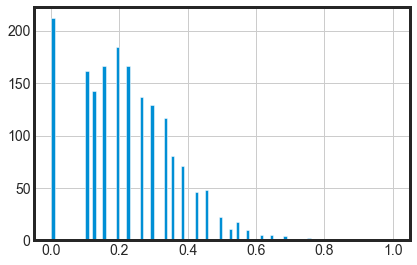

In [508]:
#For demonstration purposes, a sample is taken from the dask dataframe
dataset_fixed_bins = dataset_fixed.sample(frac=0.1, replace=True).compute()
dataset_fixed_bins.windspeed.hist(bins = 100)

# 2. Exploratory Data Analysis


## 2.1 Understand the pattern of the data

In [394]:
# Load the data again
hour = pd.read_csv('Data/hour.csv')

# Split label the weekday and months based on the calendar
import calendar
from datetime import datetime

hour["name_weekday"] = hour.dteday.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
hour["name_month"] = hour.dteday.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])

# Split the date to year, month, and day
# Recreate the dataframe
hour['date'] = hour['dteday']
hour.date = dd.to_datetime(hour.date)

# Create 3 new columns for year, month, and day
hour[['year','month','day']] = hour.date.apply(lambda x: pd.Series(x.strftime("%Y,%m,%d").split(",")))

hour['hour'] = hour['hr']

hour_dask = dd.from_pandas(hour, npartitions=3)

# Import additional libraries
import seaborn as sns
plt.style.use('fivethirtyeight')

import tkinter
sns.set_style("whitegrid")
sns.set_style("white")
sns.despine(fig=None)
import warnings
warnings.filterwarnings(action='ignore')

# Plot series


#fig.set_size_inches(15,40)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]



<Figure size 432x288 with 0 Axes>

### 2.1.1 Understanding number of bike use based on month

[Text(0, 0.5, 'Average # of bikers'),
 Text(0.5, 0, 'Month'),
 Text(0.5, 1.0, 'Average Count By Month')]

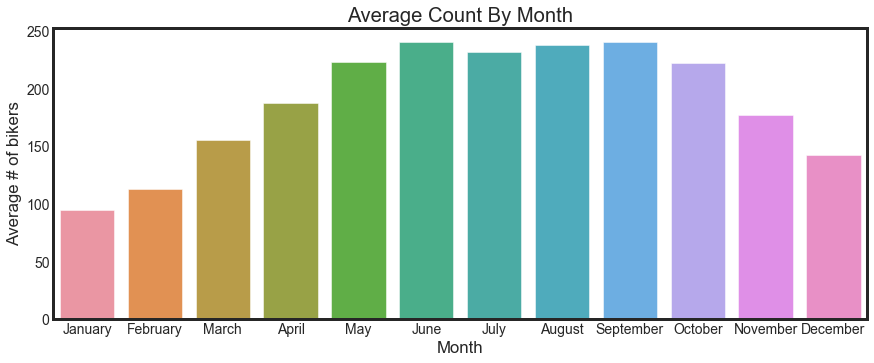

In [395]:
##Average # of bikers
from dask.dataframe.utils import make_meta
plt.figure(figsize=(13,5))

monthAggregated = (hour_dask.groupby("name_month")["cnt"].mean()).reset_index()
monthSorted = monthAggregated.compute().sort_values(by="cnt",ascending=False)
figure=sns.barplot(data=monthSorted,x="name_month",y="cnt",order=sortOrder)
figure.set(xlabel='Month', ylabel='Average # of bikers',title="Average Count By Month")

### 2.1.2 Understand number of bike use based on season

[Text(0, 0.5, 'Avearage # of bikers'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Season'),
 None]

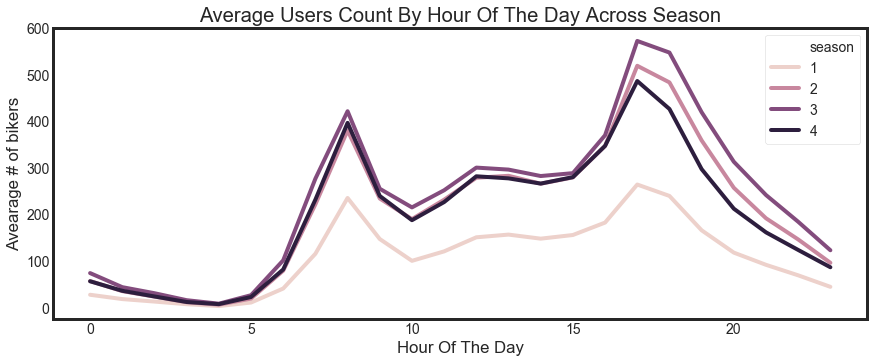

In [396]:
##Average Users Count By Hour Of The Day Across Season
plt.figure(figsize=(13,5))
hourAggregated = (hour_dask.groupby(["hour","season"])["cnt"].mean()).reset_index()
hourAggregated = hourAggregated.compute().sort_values(by="cnt",ascending=False)
figure=sns.lineplot(x=hourAggregated["hour"], y=hourAggregated["cnt"], hue=hourAggregated["season"], data=hourAggregated)
figure.set(xlabel='Hour Of The Day', ylabel='Avearage # of bikers',title="Average Users Count By Hour Of The Day Across Season",label='big')


### 2.1.3 Understand number of bike use based on Weekdays

[Text(0, 0.5, 'Avearage # of bikers'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Weekdays'),
 None]

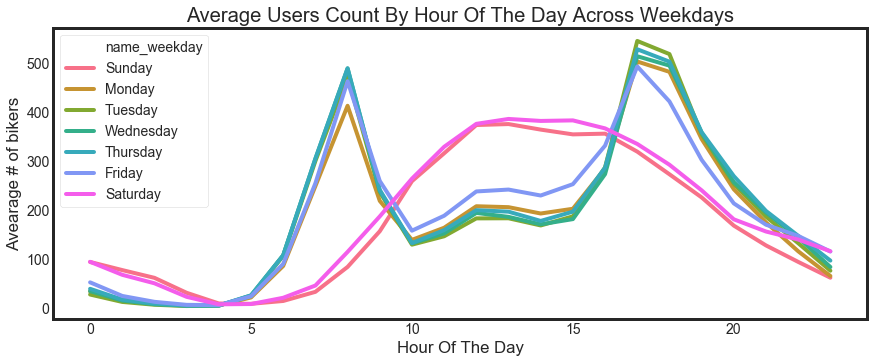

In [397]:
##Average Users Count By Hour Of The Day Across Weekdays
plt.figure(figsize=(13,5))

hourAggregated = (hour_dask.groupby(["hour","name_weekday"])["cnt"].mean()).reset_index()
hourAggregated = hourAggregated.compute().sort_values(by="cnt",ascending=False)
figure=sns.lineplot(x=hourAggregated["hour"], y=hourAggregated["cnt"],hue=hourAggregated["name_weekday"],hue_order=hueOrder, data=hourAggregated)
figure.set(xlabel='Hour Of The Day', ylabel='Avearage # of bikers',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')


### 2.1.4 Understand number of bike use based on user types

[Text(0, 0.5, 'Avearage # of bikers'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across User Type'),
 None]

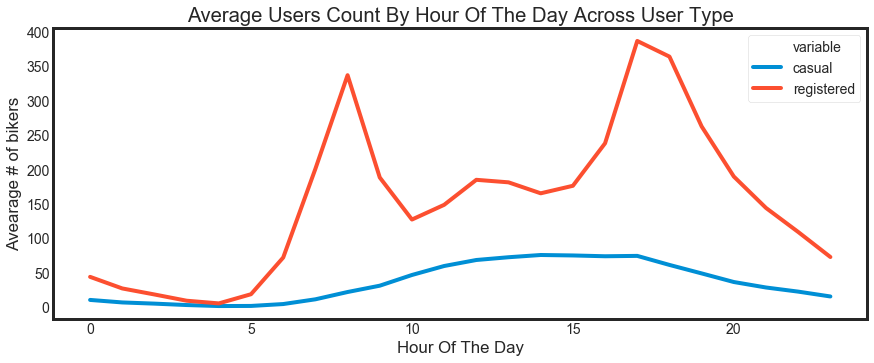

In [398]:
##Average Users Count By Hour Of The Day Across User Type
plt.figure(figsize=(13,5))

hourTransformed = dd.melt(hour_dask[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'])
hourAggregated = (hourTransformed.groupby(["hour","variable"])["value"].mean()).reset_index()
hourAggregated = hourAggregated.compute().sort_values(by="value",ascending=False)
figure=sns.lineplot(x=hourAggregated["hour"], y=hourAggregated["value"],hue=hourAggregated["variable"],hue_order=["casual","registered"], data=hourAggregated)
figure.set(xlabel='Hour Of The Day', ylabel='Avearage # of bikers',title="Average Users Count By Hour Of The Day Across User Type",label='big')


### 2.1.5 Understand casual user pattern based on workingday and the hour of the day

[Text(0, 0.5, 'Casual bikers'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Casual Users Count By Hour Of The Day Across Weekdays'),
 None]

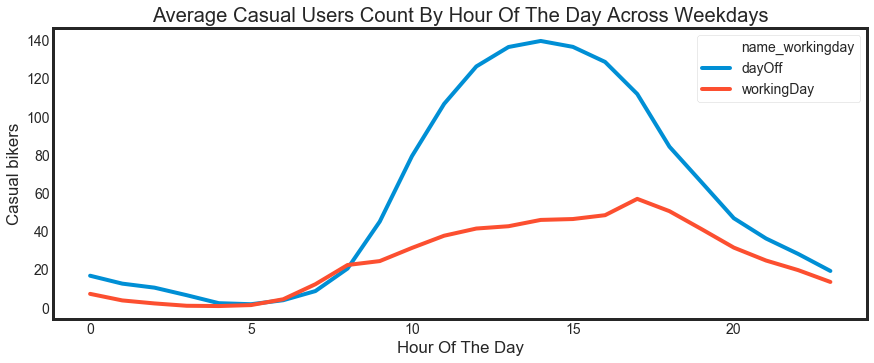

In [399]:
##Average Users Count By Hour Of The Day Across Weekdays
hour_dask['name_workingday']=hour_dask['workingday']
hour_dask['name_workingday']=hour_dask['name_workingday'].mask(hour_dask['name_workingday'] == 0, 'dayOff')
hour_dask['name_workingday']=hour_dask['name_workingday'].mask(hour_dask['name_workingday'] == 1, 'workingDay')

hueOrder_2 = ["dayOff", "workingDay"]
plt.figure(figsize=(13,5))

hourAggregated = (hour_dask.groupby(["hour","name_workingday"])["casual"].mean()).reset_index()
hourAggregated = hourAggregated.compute().sort_values(by="casual",ascending=False)
figure=sns.lineplot(x=hourAggregated["hour"], y=hourAggregated["casual"],hue=hourAggregated["name_workingday"],hue_order=hueOrder_2, data=hourAggregated)
figure.set(xlabel='Hour Of The Day', ylabel='Casual bikers',title="Average Casual Users Count By Hour Of The Day Across Weekdays",label='big')


### 2.1.6 Understand registered user pattern based on workingday and the hour of the day

[Text(0, 0.5, 'Registered bikers'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Registered Users Count By Hour Of The Day Across Weekdays'),
 None]

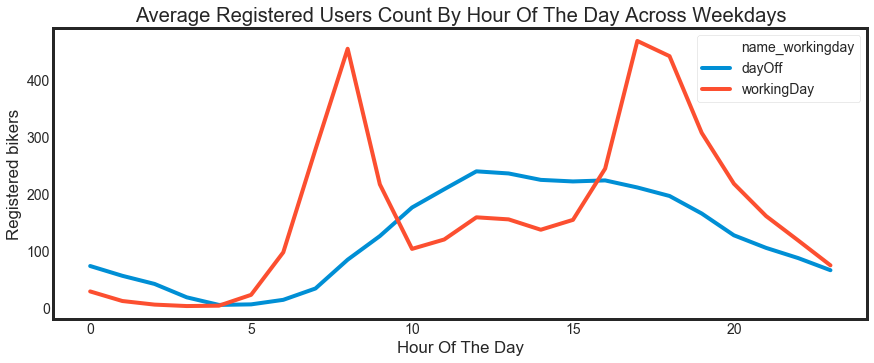

In [400]:
##Average Users Count By Hour Of The Day Across Weekdays
plt.figure(figsize=(13,5))

hourAggregated = (hour_dask.groupby(["hour","name_workingday"])["registered"].mean()).reset_index()
hourAggregated = hourAggregated.compute().sort_values(by="registered",ascending=False)
figure=sns.lineplot(x=hourAggregated["hour"], y=hourAggregated["registered"],hue=hourAggregated["name_workingday"],hue_order=hueOrder_2, data=hourAggregated)
figure.set(xlabel='Hour Of The Day', ylabel='Registered bikers',title="Average Registered Users Count By Hour Of The Day Across Weekdays",label='big')



## 2.2 Box plot to check for outliers

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

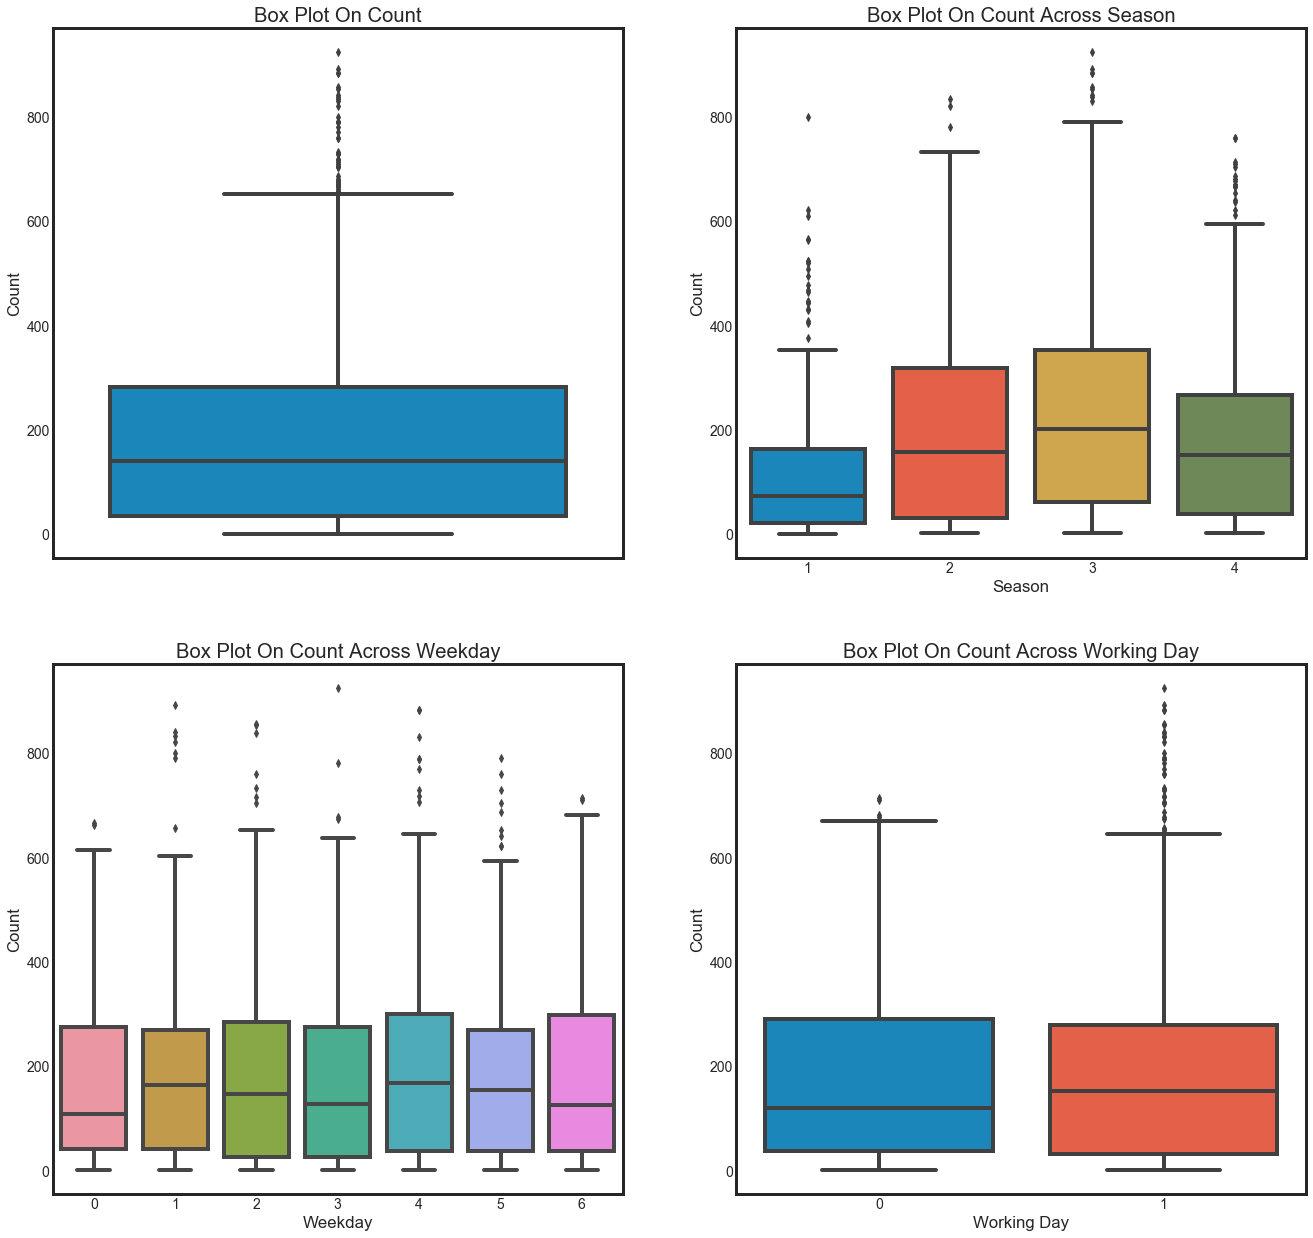

In [401]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(20, 20)

#For demonstration purposes, a sample is taken from the dask dataframe
hour_box = hour_dask.sample(frac=0.1, replace=True).compute()

sns.boxplot(data=hour_box,y="cnt",orient="v",ax=axes[0][0])
sns.boxplot(data=hour_box,y="cnt",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=hour_box,y="cnt",x="weekday",orient="v",ax=axes[1][0])
sns.boxplot(data=hour_box,y="cnt",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Weekday', ylabel='Count',title="Box Plot On Count Across Weekday")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

## 2.3 Correlation matrix 

### 2.3.1 Overall correlation matrix

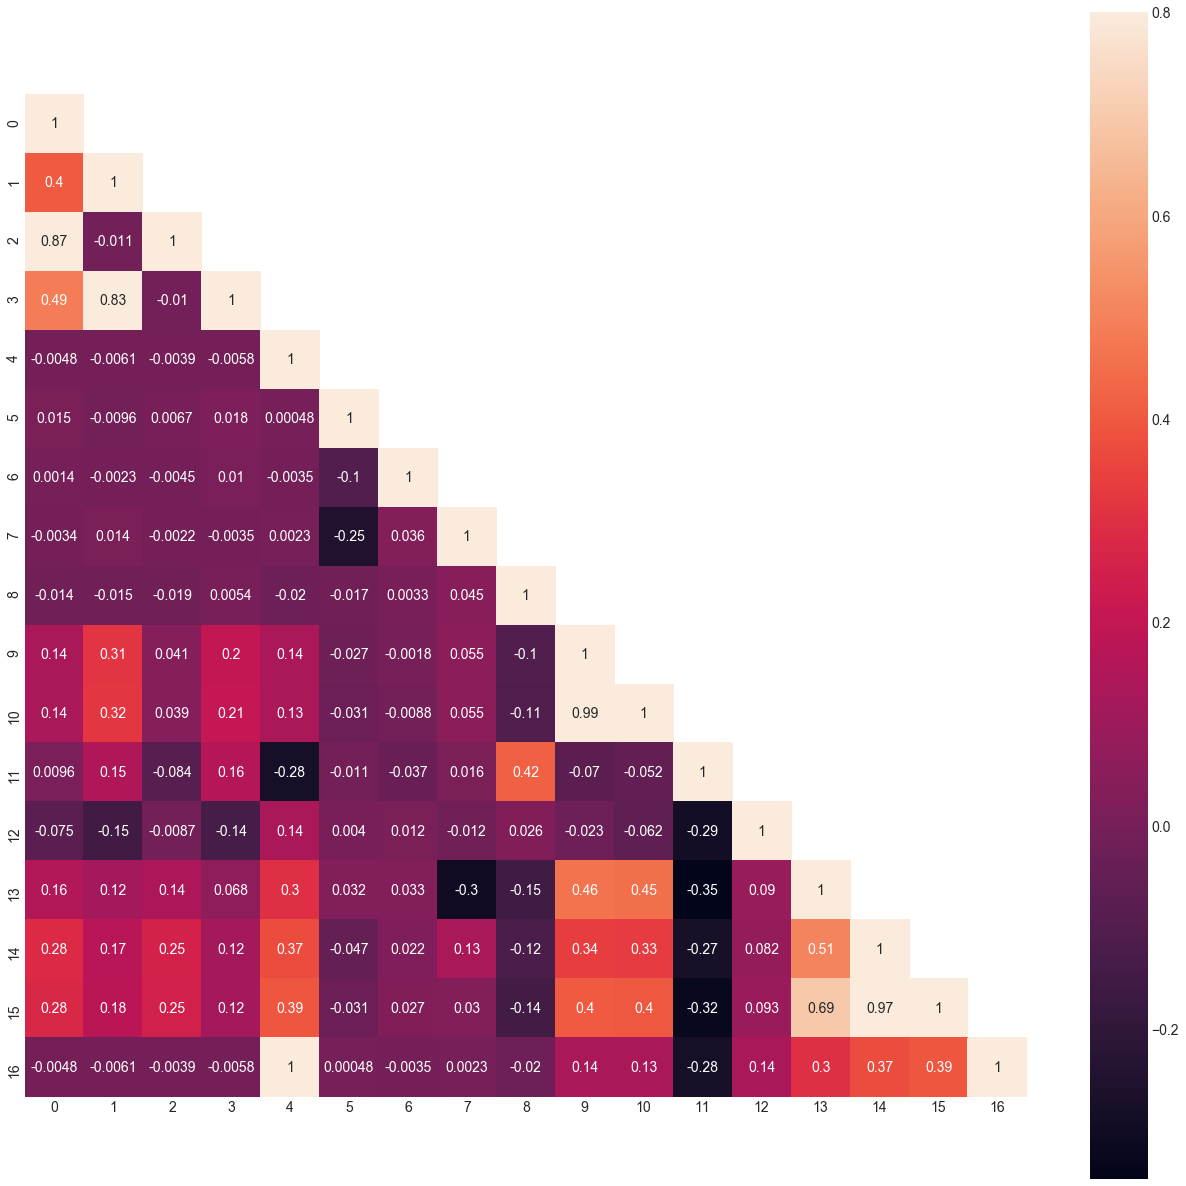

In [402]:
corr = hour_dask.corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,20)
sns.heatmap(corr, mask=mask, vmax=.8, square=True, annot=True)

### 2.3.2 Temperature and humidity and windspeed and humidity

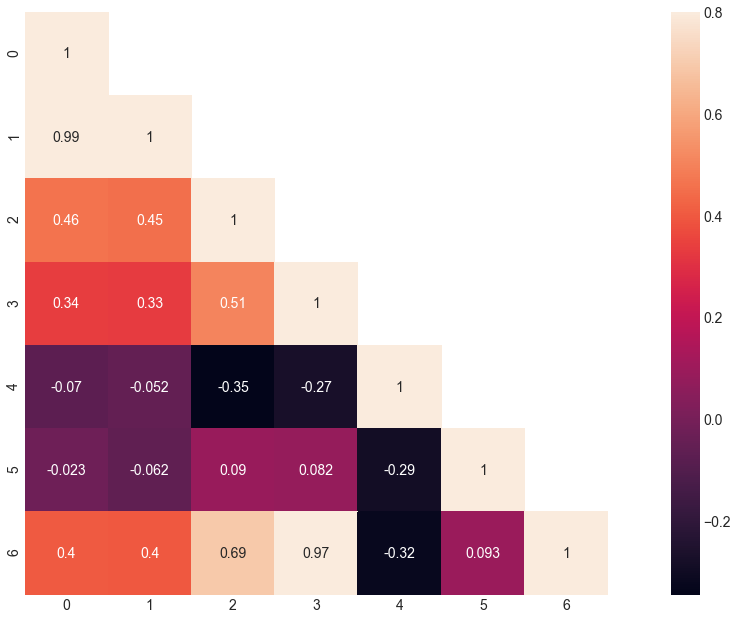

In [403]:
corr = hour_dask[["temp","atemp","casual","registered","hum","windspeed","cnt"]].corr()
mask = np.array(corr)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corr, mask=mask,vmax=.8, square=True,annot=True)

## 2.4 Distribution of wind, atemp, humidity

[Text(0, 0.5, 'number of bikes'), Text(0.5, 0, 'humidity')]

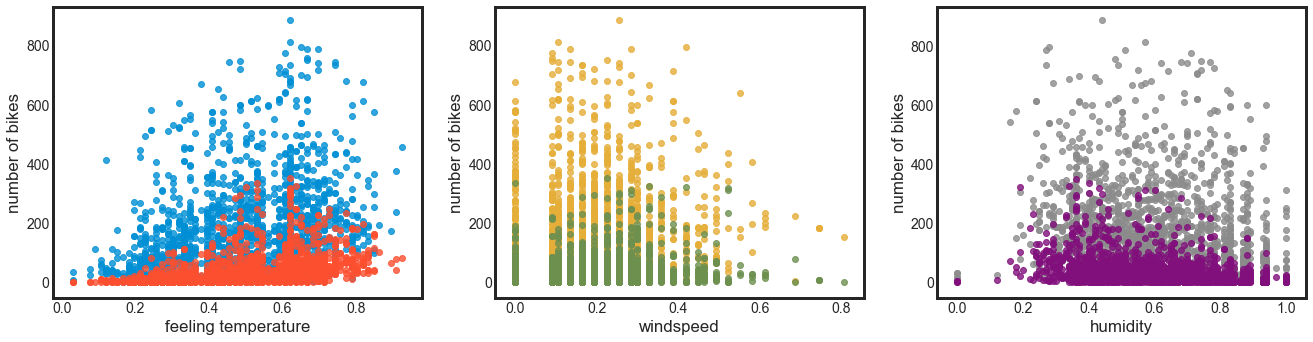

In [404]:
####Legend & y axis label????
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3)
fig.set_size_inches(20, 5)

#For demonstration purposes, a sample is taken from the dask dataframe
hour_chart = hour_dask.sample(frac=0.1, replace=True).compute()

fig1=sns.regplot(x="atemp", y="registered", data=hour_chart, ax=ax1, fit_reg = False)
fig1=sns.regplot(x="atemp", y="casual", data=hour_chart, ax=ax1, fit_reg = False)
fig1.set(xlabel='feeling temperature', ylabel='number of bikes')

fig2=sns.regplot(x="windspeed", y="registered", data=hour_chart, ax=ax2, fit_reg = False)
fig2=sns.regplot(x="windspeed", y="casual", data=hour_chart, ax=ax2, fit_reg = False)
fig2.set(xlabel='windspeed', ylabel='number of bikes')

fig3=sns.regplot(x="hum", y="registered", data=hour_chart, ax=ax3, fit_reg = False)
fig3=sns.regplot(x="hum", y="casual", data=hour_chart, ax=ax3, fit_reg = False)
fig3.set(xlabel='humidity', ylabel='number of bikes')


## 2.5 Distribution of bikers

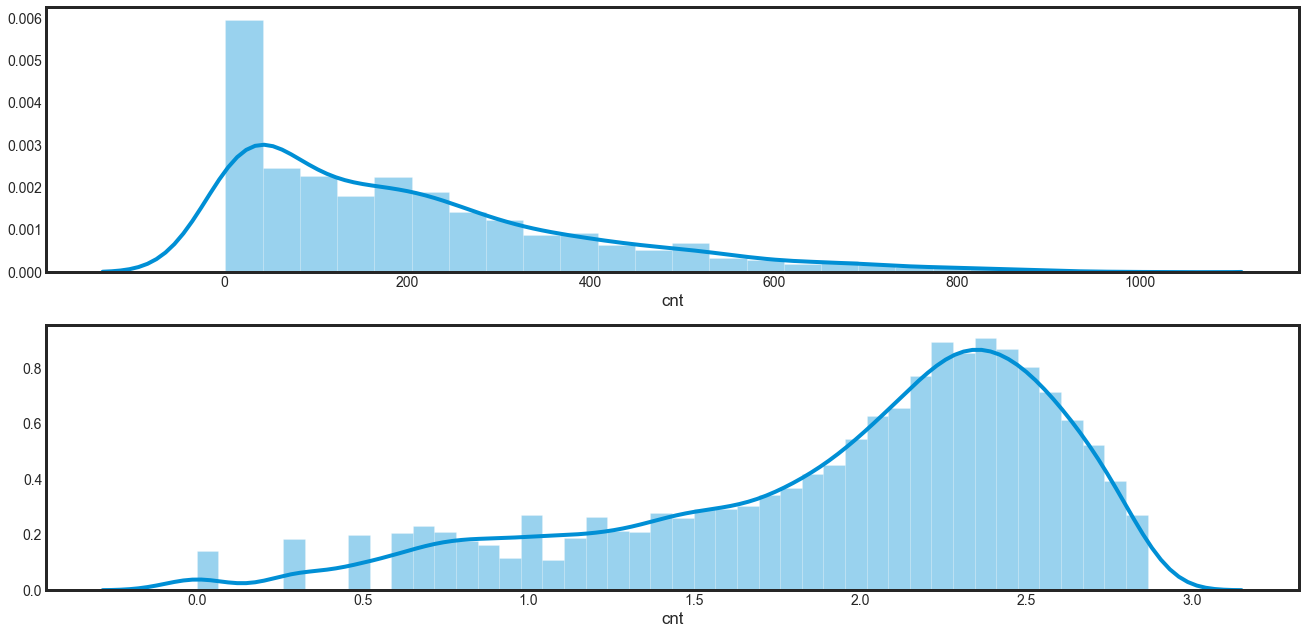

In [405]:
hour_no_outliers = hour_dask[np.abs(hour["cnt"]-hour["cnt"].mean())<=(3*hour["cnt"].std())]

fig,axes = plt.subplots(ncols=1,nrows=2)
fig.set_size_inches(20, 10)
sns.distplot(hour_chart["cnt"],ax=axes[0])
sns.distplot(np.log10(hour_no_outliers["cnt"]),ax=axes[1])

# 3. Modelling

## 3.1. Baseline model

Split in test and train set

In [197]:
test = dataset_fixed[(dataset_fixed.yr == 1) & ((dataset_fixed.dteday.dt.month == 10)|(dataset_fixed.dteday.dt.month == 11)|(dataset_fixed.dteday.dt.month == 12))]
train = dataset_fixed[:(len(dataset_fixed)-len(test))]

test = onehot_encode(test.drop(['dteday'], axis = 1))
train = onehot_encode(train.drop(['dteday'], axis = 1))

In [39]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2168 entries, 15211 to 17378
Data columns (total 38 columns):
yr              2168 non-null uint8
hr              2168 non-null int64
holiday         2168 non-null uint8
workingday      2168 non-null uint8
temp            2168 non-null float64
atemp           2168 non-null float64
hum             2168 non-null float64
windspeed       2168 non-null float64
casual          2168 non-null int64
registered      2168 non-null int64
cnt             2168 non-null int64
mnth_1          2168 non-null uint8
mnth_2          2168 non-null uint8
mnth_3          2168 non-null uint8
mnth_4          2168 non-null uint8
mnth_5          2168 non-null uint8
mnth_6          2168 non-null uint8
mnth_7          2168 non-null uint8
mnth_8          2168 non-null uint8
mnth_9          2168 non-null uint8
mnth_10         2168 non-null uint8
mnth_11         2168 non-null uint8
mnth_12         2168 non-null uint8
weekday_0       2168 non-null uint8
weekday_1       

In [40]:
test.head(2)

,yr,hr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4,season_1,season_2,season_3,season_4
15211,1,0,0,1,0.46,0.4545,0.72,0.018919,6,39,...,0,0,1,0,0,0,0,0,0,1
15212,1,1,0,1,0.44,0.4394,0.77,0.000000,5,13,...,0,0,1,0,0,0,0,0,0,1


In [41]:
train.tail(2)

,yr,hr,holiday,workingday,temp,atemp,hum,windspeed,casual,registered,...,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4,season_1,season_2,season_3,season_4
15209,1,22,0,0,0.48,0.4697,0.72,0.0,15,76,...,0,0,1,0,0,0,0,0,0,1
15210,1,23,0,0,0.48,0.4697,0.72,0.0,8,49,...,0,0,1,0,0,0,0,0,0,1


Defining the linear regression model for the baseline score

In [42]:
def score_model(train, seed = 123):
    X = train.loc[:, (train.columns != 'cnt') & (train.columns != 'casual') & (train.columns != 'registered') ]
    y = train.loc[:, 'cnt']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                        random_state=seed)        
                        
    # Create linear regression object
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = [1 if i < 0 else math.ceil(i) for i in regr.predict(X_test)]
    return r2_score(y_test, y_pred)
   

In [43]:
from sklearn.model_selection import TimeSeriesSplit
def score_model(train, test, seed = 123):
    X_train = train.loc[:, (train.columns != 'cnt') & (train.columns != 'casual') & (train.columns != 'registered') ]
    y_train = train.loc[:, 'cnt']
    
    X_test = test.loc[:, (test.columns != 'cnt') & (test.columns != 'casual') & (test.columns != 'registered') ]
    y_test = test.loc[:, 'cnt']             
                        
    cv  = TimeSeriesSplit(n_splits= 5)

    pipeline = Pipeline([
        #('polynomials', PolynomialFeatures(degree=3, include_bias=False)), 
        ('linear_regression', LinearRegression(n_jobs=-1))])
    pipeline.fit(X_train, y_train)
    
    training_score = pipeline.score(X_test, y_test)
    print ('R2 best features')
    print('R2 from entire-dataset estimator: {:.3f}'.format(training_score))

    # Obtain scores and estimators from different splits and use the best one.
    scores = cross_validate(pipeline, 
                            X_train, y_train,
                            scoring=['r2'], 
                            cv=cv,
                            return_estimator=True)
    split_scores = [scores['estimator'][i].score(X_test, y_test) 
                    for i in range(len(scores))]
    index_best = split_scores.index(max(split_scores))
    print('Best estimator R2 score: {:.3f}'.format(split_scores[index_best]))

In [44]:
score_model(train, test)

R2 best features
R2 from entire-dataset estimator: 0.323
Best estimator R2 score: 0.319


In [240]:
def score_multiple_2(train, test):
    
    model = Pipeline([
        #('polynomials', PolynomialFeatures(degree=3, include_bias=False)), 
        ('linear_regression', LinearRegression(n_jobs=-1))])
    
    splits = 1
    
    y_test = test.loc[:, 'cnt']
    predictions = []
    
    for wd in [0,1]:
        for s in range(splits):
            Xs_train = standardize_hour(train.loc[(train.workingday == wd) & (train.hr >= int(24*s/splits)) & (train.hr < int(24*(s+1)/splits)), (train.columns != 'cnt') & (train.columns != 'casual') & (train.columns != 'registered') ])
            ys_train = train.loc[(train.workingday == wd) & (train.hr >= int(24*s/splits)) & (train.hr < int(24*(s+1)/splits)), 'cnt']
            Xs_test = standardize_hour(test.loc[(test.workingday == wd) & (test.hr >= int(24*s/splits)) & (test.hr < int(24*(s+1)/splits)), (test.columns != 'cnt') & (test.columns != 'casual') & (test.columns != 'registered') ])
            ys_test = test.loc[(test.workingday == wd) & (test.hr >= int(24*s/splits)) & (test.hr < int(24*(s+1)/splits)), 'cnt']
   
            reg_s = model
            reg_s.fit(Xs_train, ys_train)
            predictions.append(pd.DataFrame(cv_best_pred_2(Xs_train, ys_train, Xs_test, ys_test, reg_s)))
    
    y_pred = pd.DataFrame(columns = list(y_test))
   
    y_pred = pd.concat(predictions).sort_index()
        
#     for i in y_test.index.values:
#         print((y_test[i], y_pred[i]))
    
    return r2_score(y_test, y_pred)
    

In [241]:
def score_multiple_3(train, test):
    
    model = Pipeline([
        #('polynomials', PolynomialFeatures(degree=3, include_bias=False)), 
        ('linear_regression', LinearRegression(n_jobs=-1))])
    
    splits = 1
    
    y_test = test.loc[:, 'cnt']
    predictions = []
    
    for wd in [0,1]:
        for s in range(splits):
            Xs_train = standardize_hour(train.loc[(train.workingday == wd) & (train.hr >= int(24*s/splits)) & (train.hr < int(24*(s+1)/splits)), (train.columns != 'cnt') & (train.columns != 'casual') & (train.columns != 'registered') ])
            ys_train = train.loc[(train.workingday == wd) & (train.hr >= int(24*s/splits)) & (train.hr < int(24*(s+1)/splits)), 'cnt']
            Xs_test = standardize_hour(test.loc[(test.workingday == wd) & (test.hr >= int(24*s/splits)) & (test.hr < int(24*(s+1)/splits)), (test.columns != 'cnt') & (test.columns != 'casual') & (test.columns != 'registered') ])
            ys_test = test.loc[(test.workingday == wd) & (test.hr >= int(24*s/splits)) & (test.hr < int(24*(s+1)/splits)), 'cnt']
   
            reg_s = model
            reg_s.fit(Xs_train, ys_train)
            predictions.append(pd.DataFrame(cv_best_pred_2(Xs_train, ys_train, Xs_test, ys_test, reg_s)))
    
    y_pred = pd.DataFrame(columns = list(y_test))
   
    y_pred = pd.concat(predictions).sort_index()
        
#     for i in y_test.index.values:
#         print((y_test[i], y_pred[i]))
    
    return y_pred
    

In [201]:
def cv_best_pred(X_train, y_train, X_test, y_test, model):
    
    cv = TimeSeriesSplit(n_splits=50)
    
    models = cross_validate(model, 
                            X_train, y_train,
                            scoring=['r2'], 
                            cv=cv,
                            return_estimator=True)
    preds = []
    scores = []
    for m in range(len(models['estimator'])):
        preds.append(pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in models['estimator'][m].predict(X_test)], index = X_test.index.values))
        scores.append(r2_score(y_test, preds[m]))
    index_best = scores.index(max(scores))
    return preds[index_best]

In [193]:
def cv_best_pred_2(X_train, y_train, X_test, y_test, model):
    
    cv = TimeSeriesSplit(n_splits=50)
    
    models = cross_validate(model, 
                            X_train, y_train,
                            scoring=['r2'], 
                            cv=cv,
                            return_estimator=True)
    preds = []
    scores = []
    for m in range(len(models['estimator'])):
        preds.append(pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in models['estimator'][m].predict(X_train)], index = X_train.index.values))
        scores.append(r2_score(y_train, preds[m]))
    index_best = scores.index(max(scores))
    
    pred = pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in models['estimator'][index_best].predict(X_test)], index = X_test.index.values)
    
    return pred

In [204]:
score_multiple_2(train, test)

0.7899145805917888

## 2. Feature Engineering (FE)

### 2. FE1.1: Dropping temp and weekday

The temperature variable is captured by the atemp variable, therefore we drop one of the two; in this case temperature.
The workingday variable is also able to capture similar information as the weekday variable, and so we drop weekday.

In [249]:
# Drop variables
dataset_FE1 = dataset_fixed.drop(['atemp','weekday'], axis = 1)

In [206]:
dataset_FE1.head(2)

,dteday,season,yr,mnth,hr,holiday,workingday,weathersit,atemp,hum,windspeed,casual,registered,cnt,cluster,temphum
0,2011-01-01,1,0,1,0,0,0,1,0.2879,0.81,0.0,3,13,16,43,0.1944
1,2011-01-01,1,0,1,1,0,0,1,0.2727,0.80,0.0,8,32,40,43,0.1760


In [250]:
test = dataset_FE1[(dataset_FE1.yr == 1) & ((dataset_FE1.dteday.dt.month == 10)|(dataset_FE1.dteday.dt.month == 11)|(dataset_FE1.dteday.dt.month == 12))]
train = dataset_FE1[:(len(dataset_FE1)-len(test))]

test = onehot_encode(test.drop(['dteday'], axis = 1))
train = onehot_encode(train.drop(['dteday'], axis = 1))

In [208]:
score_model(train, test)

R2 best features
R2 from entire-dataset estimator: 0.303
Best estimator R2 score: 0.307


In [251]:
score_multiple_2(train, test)

0.7830816802738607

### 2. FE1.2: Dropping atemp

In [253]:
# Drop variables
dataset_FE1 = dataset_fixed.drop(['atemp'], axis = 1)

In [254]:
dataset_FE1.head(2)

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,casual,registered,cnt,cluster,temphum
0,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.81,0.0,3,13,16,43,0.1944
1,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.80,0.0,8,32,40,43,0.1760


In [255]:
test = dataset_FE1[(dataset_FE1.yr == 1) & ((dataset_FE1.dteday.dt.month == 10)|(dataset_FE1.dteday.dt.month == 11)|(dataset_FE1.dteday.dt.month == 12))]
train = dataset_FE1[:(len(dataset_FE1)-len(test))]

test = onehot_encode(test.drop(['dteday'], axis = 1))
train = onehot_encode(train.drop(['dteday'], axis = 1))

In [256]:
score_model(train, test)

R2 best features
R2 from entire-dataset estimator: 0.305
Best estimator R2 score: 0.308


In [257]:
score_multiple_2(train, test)

0.7898968736020748

### 2. FE2: Grouping hours and temperature

In [210]:
# Group hours based on pattern for casual users
dataset_FE2 = dataset_fixed.drop(['temp','weekday'], axis = 1)
dataset_FE2.head(2)

,dteday,season,yr,mnth,hr,holiday,workingday,weathersit,atemp,hum,windspeed,casual,registered,cnt,cluster,temphum
0,2011-01-01,1,0,1,0,0,0,1,0.2879,0.81,0.0,3,13,16,43,0.1944
1,2011-01-01,1,0,1,1,0,0,1,0.2727,0.80,0.0,8,32,40,43,0.1760


In [211]:
dataset_FE2['hour'] = pd.cut(dataset_FE2['hr'],[-1,6,12,17,23], labels=["Early_Morning", "Morning", "Afternon","Evening"])

In [212]:
dataset_FE2.head(2)

,dteday,season,yr,mnth,hr,holiday,workingday,weathersit,atemp,hum,windspeed,casual,registered,cnt,cluster,temphum,hour
0,2011-01-01,1,0,1,0,0,0,1,0.2879,0.81,0.0,3,13,16,43,0.1944,Early_Morning
1,2011-01-01,1,0,1,1,0,0,1,0.2727,0.80,0.0,8,32,40,43,0.1760,Early_Morning


In [213]:
dataset_FE2.hour.unique()

[Early_Morning, Morning, Afternon, Evening]
Categories (4, object): [Early_Morning < Morning < Afternon < Evening]

In [214]:
dataset_FE2["hour"] = dataset_FE2["hour"].astype('category').cat.codes
dataset_FE2["hour"] = dataset_FE2["hour"].astype('category')

In [215]:
dataset_FE2.hour.unique()

[0, 1, 2, 3]
Categories (4, int64): [0, 1, 2, 3]

In [216]:
dataset_FE2['atemp_level']=pd.cut(dataset_FE2['atemp'],3, labels=["cold", "regular", "hot"])
dataset_FE2["atemp_level"] = dataset_FE2["atemp_level"].astype('category').cat.codes
dataset_FE2["atemp_level"] = dataset_FE2["atemp_level"].astype('category')

In [217]:
dataset_FE2.head(2)

,dteday,season,yr,mnth,hr,holiday,workingday,weathersit,atemp,hum,windspeed,casual,registered,cnt,cluster,temphum,hour,atemp_level
0,2011-01-01,1,0,1,0,0,0,1,0.2879,0.81,0.0,3,13,16,43,0.1944,0,0
1,2011-01-01,1,0,1,1,0,0,1,0.2727,0.80,0.0,8,32,40,43,0.1760,0,0


In [218]:
test = dataset_FE2[(dataset_FE2.yr == 1) & ((dataset_FE2.dteday.dt.month == 10)|(dataset_FE2.dteday.dt.month == 11)|(dataset_FE2.dteday.dt.month == 12))]
train = dataset_FE2[:(len(dataset_FE2)-len(test))]

test = onehot_encode(test.drop(['dteday'], axis = 1))
train = onehot_encode(train.drop(['dteday'], axis = 1))

In [219]:
score_model(train, test)

R2 best features
R2 from entire-dataset estimator: 0.467
Best estimator R2 score: 0.465


In [220]:
score_multiple_2(train, test)

0.7816615342962635

### 2. FE3: Drop month but keep seasons

In [221]:
def drop_month(df):
    df = df.drop(['atemp', 'mnth'], axis = 1)
    
    return df

In [222]:
dataset_FE3 = drop_month(dataset_fixed)

In [223]:
test = dataset_FE3[(dataset_FE3.yr == 1) & ((dataset_FE3.dteday.dt.month == 10)|(dataset_FE3.dteday.dt.month == 11)|(dataset_FE3.dteday.dt.month == 12))]
train = dataset_FE3[:(len(dataset_FE3)-len(test))]

test = onehot_encode(test.drop(['dteday'], axis = 1))
train = onehot_encode(train.drop(['dteday'], axis = 1))

In [67]:
score_model(train, test)

R2 best features
R2 from entire-dataset estimator: 0.322
Best estimator R2 score: 0.315


In [224]:
score_multiple_2(train, test)

0.7995339141045312

### 2. FE4: Clustering weather condition

In [225]:
def getKMeans (df,numberOfClusters = 50 ):
    kmeans = KMeans(n_clusters=numberOfClusters, random_state=123).fit(df[['temp','hum', 'windspeed']])
    df['cluster'] = kmeans.labels_
    df[['cluster']] = df[['cluster']].astype('category')
    return df

In [229]:
dataset_FE4 = getKMeans(dataset_fixed)

In [230]:
test = dataset_FE4[(dataset_FE4.yr == 1) & ((dataset_FE4.dteday.dt.month == 10)|(dataset_FE4.dteday.dt.month == 11)|(dataset_FE4.dteday.dt.month == 12))]
train = dataset_FE4[:(len(dataset_FE4)-len(test))]

test = onehot_encode(test.drop(['dteday'], axis = 1))
train = onehot_encode(train.drop(['dteday'], axis = 1))

In [72]:
score_model(train, test)

R2 best features
R2 from entire-dataset estimator: 0.305
Best estimator R2 score: 0.308


In [231]:
score_multiple_2(train, test)

0.7899145805917888

### 2. FE5: Combining weather variabes

In [232]:
def combine_weather (df):
    df['temphum'] = df['hum']*df['temp']
    

    return df

In [233]:
dataset_FE5 = combine_weather(dataset_fixed)

In [234]:
test = dataset_FE5[(dataset_FE5.yr == 1) & ((dataset_FE5.dteday.dt.month == 10)|(dataset_FE5.dteday.dt.month == 11)|(dataset_FE5.dteday.dt.month == 12))]
train = dataset_FE5[:(len(dataset_FE5)-len(test))]

test = onehot_encode(test.drop(['dteday'], axis = 1))
train = onehot_encode(train.drop(['dteday'], axis = 1))

In [77]:
score_model(train, test)

R2 best features
R2 from entire-dataset estimator: 0.306
Best estimator R2 score: 0.308


In [235]:
score_multiple_2(train, test)

0.7899145805917888

### 2. FE6: External data: rush hour

In [236]:
def rush_hour(row):
    if (row['hr'] >=7 and row['hr']<=9 and row['workingday'] == 1):
        return 1
    elif (row['hr'] >=17 and row['hr']<=19 and row['workingday'] == 1):
        return 1
    else:
        return 0
    
def add_rush_hour(df):
    new_df = df.copy()
    new_df['rush_hour'] = df.apply(lambda row: rush_hour(row), axis = 1)
    return new_df

In [237]:
dataset_FE6 = add_rush_hour(dataset_fixed)

In [238]:
test = dataset_FE6[(dataset_FE6.yr == 1) & ((dataset_FE6.dteday.dt.month == 10)|(dataset_FE6.dteday.dt.month == 11)|(dataset_FE6.dteday.dt.month == 12))]
train = dataset_FE6[:(len(dataset_FE6)-len(test))]

test = onehot_encode(test.drop(['dteday'], axis = 1))
train = onehot_encode(train.drop(['dteday'], axis = 1))

In [82]:
score_model(train, test)

R2 best features
R2 from entire-dataset estimator: 0.591
Best estimator R2 score: 0.580


In [239]:
score_multiple_2(train, test)

0.7914409685076698

### 2. FE7: GP Feature Generation

In [242]:
def gp_features(df):
    X = df.loc[:, (df.columns != 'cnt') & (df.columns != 'casual') & (df.columns != 'registered') & (df.columns != 'dteday') ]
    y = df.loc[:, 'cnt']   
    
    function_set = ['add', 'sub', 'mul', 'div', 'sqrt', 'log', 'abs', 'neg', 
                'inv', 'max', 'min', 'sin', 'cos', 'tan']
    gp = SymbolicTransformer(generations=10, population_size=1000,
                         hall_of_fame=100, n_components=12,
                         function_set=function_set,
                         parsimony_coefficient=0.0005,
                         max_samples=0.9, verbose=0,
                         random_state=123, n_jobs=-1)
    gp.fit(pd.get_dummies(X), y)
    gp_features = gp.transform(pd.get_dummies(X))

    feats = pd.DataFrame(gp_features)
    feats.columns = ['gp{}'.format(i) for i in range(len(list(feats)))]
    df = pd.concat([df, feats], axis = 1)
    
    return df

In [243]:
dataset_FE7 = gp_features(dataset_fixed)


In [244]:
test = dataset_FE7[(dataset_FE7.yr == 1) & ((dataset_FE7.dteday.dt.month == 10)|(dataset_FE7.dteday.dt.month == 11)|(dataset_FE7.dteday.dt.month == 12))]
train = dataset_FE7[:(len(dataset_FE7)-len(test))]

test = onehot_encode(test.drop(['dteday'], axis = 1))
train = onehot_encode(train.drop(['dteday'], axis = 1))

In [665]:
score_model(train, test)

R2 best features
R2 from entire-dataset estimator: 0.589
Best estimator R2 score: 0.578


In [245]:
score_multiple_2(train, test)

0.835145292415856

### Engineered data

In [246]:
dataset_eng = getKMeans(drop_month(add_rush_hour(gp_features(dataset_fixed))))

In [247]:
test = dataset_eng[(dataset_eng.yr == 1) & ((dataset_eng.dteday.dt.month == 10)|(dataset_eng.dteday.dt.month == 11)|(dataset_eng.dteday.dt.month == 12))]
train = dataset_eng[:(len(dataset_eng)-len(test))]

test = onehot_encode(test.drop(['dteday'], axis = 1))
train = onehot_encode(train.drop(['dteday'], axis = 1))

In [248]:
score_multiple_2(train, test)

0.8372234460221122

In [105]:
dataset_eng.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 28 columns):
dteday        17379 non-null datetime64[ns]
season        17379 non-null category
yr            17379 non-null uint8
hr            17379 non-null int64
holiday       17379 non-null uint8
weekday       17379 non-null category
workingday    17379 non-null uint8
weathersit    17379 non-null category
temp          17379 non-null float64
hum           17379 non-null float64
windspeed     17379 non-null float64
casual        17379 non-null int64
registered    17379 non-null int64
cnt           17379 non-null int64
cluster       17379 non-null category
temphum       17379 non-null float64
gp0           17379 non-null float64
gp1           17379 non-null float64
gp2           17379 non-null float64
gp3           17379 non-null float64
gp4           17379 non-null float64
gp5           17379 non-null float64
gp6           17379 non-null float64
gp7           17379 non-null float64
gp8   

## 3. Gradient Boosting - RSME

In [107]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

X_train = train.loc[:, (train.columns != 'cnt') & (train.columns != 'casual') & (train.columns != 'registered') ]
y_train = train.loc[:, 'cnt']
    
X_test = test.loc[:, (test.columns != 'cnt') & (test.columns != 'casual') & (test.columns != 'registered') ]
y_test = test.loc[:, 'cnt']   

gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)
gbm.fit(X = X_train,y = y_train)
preds_GB_RSME = pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in gbm.predict(X= X_test)], index = X_test.index.values)
preds_train_GB_RSME = pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in gbm.predict(X= X_train)], index = X_train.index.values)
print ("RMSE Value: {:.3f} ".format(mean_squared_error(y_test, preds_GB_RSME)))
print ("R2 score: {:.3f} ".format(r2_score(preds_GB_RSME, y_test)))

RMSE Value: 4910.366 
R2 score: 0.847 


## 4. Gradient Boosting - RMSLE

In [108]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01); ### Test 0.41

def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

X_train = train.loc[:, (train.columns != 'cnt') & (train.columns != 'casual') & (train.columns != 'registered')]
y_train = train.loc[:, 'cnt']
    
X_test = test.loc[:, (test.columns != 'cnt') & (test.columns != 'casual') & (test.columns != 'registered')]
y_test = test.loc[:, 'cnt'] 

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

gbm.fit(X_train, y_train_log)
preds_GB_RSMLE = gbm.predict(X = X_test)
preds_train_GB_RSMLE = pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in np.exp(gbm.predict(X = X_train))])
print ("RMSLE Value For Gradient Boost: {:.3f} ".format(rmsle(np.exp(y_test_log),np.exp(preds_GB_RSMLE),False)))
print ("R2 score: {:.3f} ".format(r2_score(pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in np.exp(preds_GB_RSMLE)]),y_test)))


RMSLE Value For Gradient Boost: 0.409 
R2 score: 0.876 


## 5. Regularization Model - Ridge

In [109]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log2 - log1) ** 2
    return np.sqrt(np.mean(calc))

X_train = train.loc[:, (train.columns != 'cnt') & (train.columns != 'casual') & (train.columns != 'registered')]
y_train = train.loc[:, 'cnt']
    
X_test = test.loc[:, (test.columns != 'cnt') & (test.columns != 'casual') & (test.columns != 'registered')]
y_test = test.loc[:, 'cnt'] 

ridge_m_ = Ridge()
ridge_params_ = { 'max_iter':[3000],'alpha':[0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge_m = GridSearchCV( ridge_m_,
                          ridge_params_,
                          scoring = rmsle_scorer,
                          cv=5)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

grid_ridge_m.fit( X_train, y_train_log )
preds_ridge = grid_ridge_m.predict(X= X_test)
print (grid_ridge_m.best_params_)
print ("RMSLE Value For Ridge Regression: {:.3f} ".format(rmsle(np.exp(y_test_log),np.exp(preds_ridge),False)))
print ("R2 score: {:.3f} ".format(r2_score(preds_ridge, y_test_log)))

#fig,ax= plt.subplots()
#fig.set_size_inches(12,5)
#df = pd.DataFrame(grid_ridge_m.grid_scores_)
#df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
#df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
#sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

{'alpha': 1, 'max_iter': 3000}
RMSLE Value For Ridge Regression: 0.737 
R2 score: 0.433 


In [110]:
r2_score(pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in np.exp(preds_ridge)]),y_test)

-0.03185384525889301

## 6. Regularization - LASSO

In [111]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

X_train = train.loc[:, (train.columns != 'cnt') & (train.columns != 'casual') & (train.columns != 'registered')]
y_train = train.loc[:, 'cnt']
    
X_test = test.loc[:, (test.columns != 'cnt') & (test.columns != 'casual') & (test.columns != 'registered')]
y_test = test.loc[:, 'cnt'] 

lasso_m_ = Lasso()

alpha  = 1/np.array([0.1, 1, 2, 3, 4, 10, 30,100,200,300,400,800,900,1000])
lasso_params_ = { 'max_iter':[3000],'alpha':alpha}

grid_lasso_m = GridSearchCV( lasso_m_,lasso_params_,scoring = rmsle_scorer,cv=5)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

grid_lasso_m.fit( X_train, y_train_log )
preds_lasso = grid_lasso_m.predict(X= X_test)
print (grid_lasso_m.best_params_)
print ("RMSLE Value For Lasso Regression: {:.3f} ".format(rmsle(np.exp(y_test_log),np.exp(preds_lasso),False)))
print ("R2 score: {:.3f} ".format(r2_score(preds_lasso, y_test_log)))

#fig,ax= plt.subplots()
#fig.set_size_inches(12,5)
#df = pd.DataFrame(grid_lasso_m.grid_scores_)
#df["alpha"] = df["parameters"].apply(lambda x:x["alpha"])
#df["rmsle"] = df["mean_validation_score"].apply(lambda x:-x)
#sn.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

C:\Users\tello\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\tello\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\tello\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\tello\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increa

{'alpha': 0.001, 'max_iter': 3000}
RMSLE Value For Lasso Regression: 0.752 
R2 score: 0.364 


C:\Users\tello\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [112]:
r2_score(pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in np.exp(preds_lasso)]),y_test)

-0.18910151231865524

## 7. Random Forest

In [113]:
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import warnings
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore", category=DeprecationWarning)

X_train = train.loc[:, (train.columns != 'cnt') & (train.columns != 'casual') & (train.columns != 'registered') ]
y_train = train.loc[:, 'cnt']
    
X_test = test.loc[:, (test.columns != 'cnt') & (test.columns != 'casual') & (test.columns != 'registered') ]
y_test = test.loc[:, 'cnt']

rfModel = RandomForestRegressor(n_estimators=100)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

rfModel.fit(X_train,y_train_log)
preds_rforest = rfModel.predict(X = X_test)
preds_train_rforest = pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in np.exp(rfModel.predict(X = X_train))])
print ("RMSLE Value For Random Forest: {:.3f} ".format(rmsle(np.exp(y_test_log),np.exp(preds_rforest),False)))
print ("R2 score: {:.3f} ".format(r2_score(preds_rforest, y_test_log)))

RMSLE Value For Random Forest: 0.437 
R2 score: 0.892 


In [114]:
r2_score(pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in np.exp(preds_rforest)]),y_test)

0.8024081905294489

## Combining best models from above

In [155]:
y_preds =(score_multiple_3(train, test))

In [174]:
## All models

pred1 = pd.Series(y_preds[0]) # R2 = 0.83
pred2 = (preds_GB_RSME)  # R2 = 0.846
pred3 = np.exp(preds_GB_RSMLE)  # R2 = 0.867
pred4 = np.exp(preds_lasso) # R2 = 0.532
pred5 = np.exp(preds_ridge) # R2 = 0.598
pred6 = (np.exp(preds_rforest)) # R2 = 0.726


In [175]:
## Averaging method

preds_avg=(pred1 + pred3 + pred6)/3

r2_score(pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in preds_avg]),y_test)

0.8246092603523913

In [176]:
## Weighted method

preds_weight=[(pred1*0.2+pred3*0.5+pred6*0.3) for pred1,pred3,pred6 in zip(pred1,pred3,pred6)]

r2_score(pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in preds_weight]),y_test)

0.8339806690123776

Text(0, 0.5, 'cumulative explained variance')

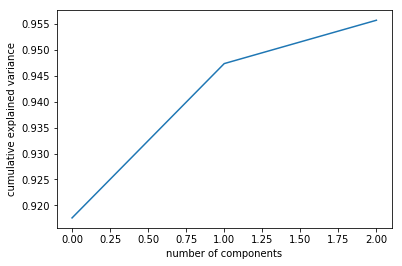

In [125]:
pca = PCA(n_components = 3, random_state = 1223)
pca.fit(X_train)

#Apply PCA to X train set and join with Y train set
X_pca_train = pd.DataFrame(pca.fit_transform(X_train))
PCA_train = X_pca_train.join(y_train)

#Apply PCA to X test set
X_pca_test = pd.DataFrame(pca.fit_transform(X_test), index = X_test.index.values)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [130]:
## Predictions as new feature

X_train_preds = pd.concat([preds_train_GB_RSME, preds_train_GB_RSMLE, preds_train_rforest], axis=1)
X_train = train.loc[:, (train.columns != 'cnt') & (train.columns != 'casual') & (train.columns != 'registered') ]
y_train = train.loc[:, 'cnt']
    
X_test_preds = pd.concat([preds_GB_RSME, pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in np.exp(preds_GB_RSMLE)], index = y_test.index.values), pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in np.exp(preds_rforest)], index = y_test.index.values)], axis=1)
X_test = test.loc[:, (test.columns != 'cnt') & (test.columns != 'casual') & (test.columns != 'registered') ]
y_test = test.loc[:, 'cnt']

X_train_total = pd.concat([X_pca_train, X_train_preds], axis = 1)
X_test_total = pd.concat([X_pca_test, X_test_preds], axis = 1)

reg = make_pipeline(
    PolynomialFeatures(degree=2, include_bias=False), 
    GradientBoostingRegressor(n_estimators=4000,alpha=0.01))
#reg.fit(X_train_total, y_train)
#y_pred = pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in reg.predict(X= X_test_total)], index = X_test_total.index.values)

r2_score(y_pred, y_test)

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

reg.fit(X_train_total, y_train_log)
preds_GB_RSMLE = reg.predict(X = X_test_total)
preds_train_GB_RSMLE = pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in np.exp(reg.predict(X = X_train_total))])
print ("RMSLE Value For Gradient Boost: {:.3f} ".format(rmsle(np.exp(y_test_log),np.exp(preds_GB_RSMLE),False)))
print ("R2 score: {:.3f} ".format(r2_score(pd.Series([1 if (i < 0 or i > 1000) else math.ceil(i) for i in np.exp(preds_GB_RSMLE)]),y_test)))

RMSLE Value For Gradient Boost: 0.447 
R2 score: 0.845 


# 4. Prediction Visualization

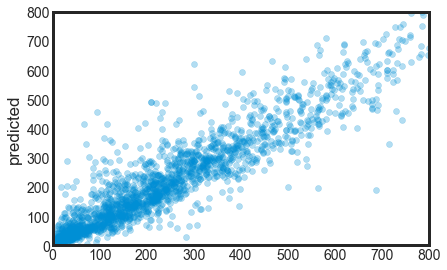

In [258]:
y_test = test.loc[:, 'cnt']


plt.scatter(y_test, pred3, alpha=0.3)
plt.ylabel('predicted')
plt.xlim(1, 800)
plt.ylim(1, 800)
plt.show();